In [1]:
import matplotlib.pyplot as plt
import tqdm
import random
import numpy as np
import json
import os
import glob
from collections import Counter
from clinical import *
import seaborn as sns

In [2]:
json_files = glob.glob('high_temp_50/*.json')
# json_files = glob.glob('high_temp_results/*.json')

In [3]:
file = json_files[-1]
with open(file, 'r') as f:
    data = json.load(f)

In [4]:
responses = []
ground_truth = []
for report in data.values():
    responses.append(report['data'])
    ground_truth.append(report['ground_truth'])

In [5]:
def vote(responses, threshold, correct):
    mode, count = calc_mode(responses)
    if len(mode) > 1:
        return 0
    else:
        if mode[0] == 'N/A':
            mode = -1
        else:
            mode = int(float(mode[0]))
        if correct[0] == 'N/A':
            correct = -1
        else:
            correct = int(float(correct[0]))
    if count/len(responses) < threshold:
        return 0
    elif mode == correct:
        return 1
    else:
        return -1

In [6]:
results = [vote(responses[i], 1, ground_truth[i]) for i in range(len(responses))]

### Plotting

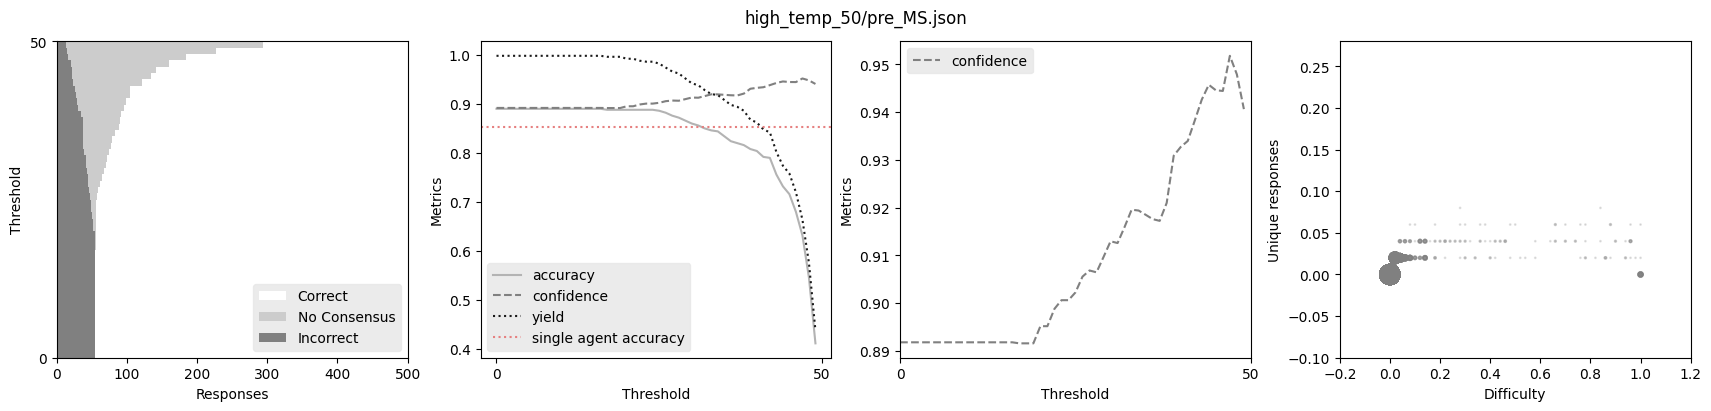

In [7]:
file = json_files[0]
with open(file, 'r') as f:
    data = json.load(f)

responses = []
ground_truth = []
for report in data.values():
    responses.append(report['data'])
    ground_truth.append(report['ground_truth'])

thresholds = 50
running_vals = [[vote_count([vote(responses[i], thresh, ground_truth[i]) for i in range(len(responses))]) for thresh in np.linspace(0, 1, thresholds)]]
answers = ground_truth

mean_values = np.mean(np.array(running_vals), axis=0)

accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
accuracy_mean = np.nanmean(accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

confidence = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
confidence_mean = np.nanmean(confidence, axis=0)

confidence_std = np.nanstd(confidence, axis=0)
confidence_lower = np.nanpercentile(confidence, 2.5, axis=0)
confidence_upper = np.nanpercentile(confidence, 97.5, axis=0)

difficulty = []
for i in range(len(responses)):
    difficulty.append(1-np.sum(np.array(responses[i]) == answers[i])/len(responses[i]))
single_model_acc = 1-float(np.mean(np.array(difficulty)))


fig, ax = plt.subplots(1,4, figsize=(17,4), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, len(answers)])
ax[0].set_yticks([0, thresholds])
ax[0].set_ylabel('Threshold')
ax[0].set_xlabel('Responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(accuracy_mean, color=[0.7,0.7,0.7], label='accuracy')
ax[1].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('Metrics')
ax[1].set_xlabel('Threshold')
ax[1].set_xticks([0, thresholds])
ax[1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[1].legend(loc = 'lower left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[2].set_ylabel('Metrics')
ax[2].set_xlabel('Threshold')
ax[2].set_xlim([0, thresholds])
ax[2].set_xticks([0, thresholds])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# entropy = normalized_entropy(responses)
entropy = simple_entropy(responses)

# ax[3].scatter(entropy, color=[0.5,0.5,0.5], linestyle='--', label='entropy')
c = Counter(zip(difficulty,entropy))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
ax[3].scatter(difficulty, entropy, s=s, color=[0.5, 0.5, 0.5], alpha=0.2)
ax[3].set_xlim([-0.2, 1.2])
ax[3].set_ylim([-0.1, max(entropy)+0.2])
ax[3].set_xlabel('Difficulty')
ax[3].set_ylabel('Unique responses')

plt.suptitle(f'{file}')
plt.savefig('clinical_pre_MS.pdf', format='pdf')

0.156401906237706
0.39547680872297175


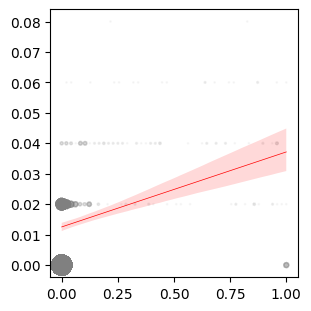

In [8]:
import statsmodels.api as sm
confusion = (np.array(difficulty) - np.array(entropy))/(1 - np.array(entropy))
confusion2 = sm.add_constant(confusion)
model = sm.OLS(entropy, confusion2).fit()
R2 = model.rsquared
print(R2)
print(np.sqrt(R2))

fig, ax = plt.subplots(1,1, figsize=(3,3), constrained_layout=True)
c = Counter(zip(difficulty,entropy))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
sns.regplot(ax=ax, x=confusion, y=entropy, scatter_kws={'alpha':0.05, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5})

MS_confusion = confusion
MS_uncertainty = entropy
MS_p = np.sqrt(R2)

0.24286331457164323


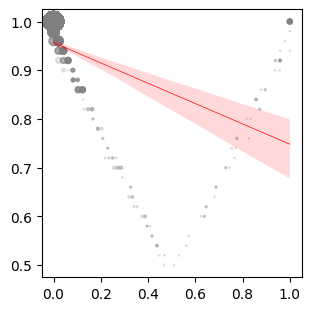

In [10]:
import statsmodels.api as sm
confusion = (np.array(difficulty) - np.array(entropy))/(1 - np.array(entropy))
f = fmax(responses, difficulty)
confusion2 = sm.add_constant(confusion)
model = sm.OLS(f, confusion2).fit()
R2 = model.rsquared
print(R2)

fig, ax = plt.subplots(1,1, figsize=(3,3), constrained_layout=True)
c = Counter(zip(difficulty,f))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,f)]
sns.regplot(ax=ax, x=confusion, y=f, scatter_kws={'alpha':0.2, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5})

MS_confusion = confusion
MS_fmax = f
MS_p = np.sqrt(R2)

(-0.05, 0.13)

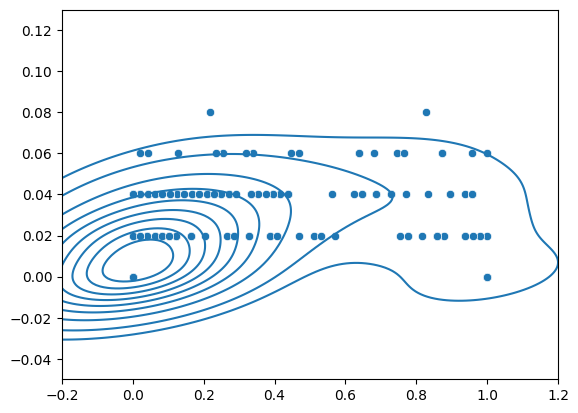

In [11]:
sns.kdeplot(
    x=confusion, y=entropy,
    levels=10,
    bw_adjust=2,
)
sns.scatterplot(x=confusion, y=entropy)

plt.gca().set_xlim([-0.2, 1.2])
plt.gca().set_ylim([-0.05, max(entropy)+0.05])

In [12]:
confidence

array([[0.89178357, 0.89178357, 0.89178357, 0.89178357, 0.89178357,
        0.89178357, 0.89178357, 0.89178357, 0.89178357, 0.89178357,
        0.89178357, 0.89178357, 0.89178357, 0.89178357, 0.89178357,
        0.89178357, 0.89178357, 0.89156627, 0.89156627, 0.89156627,
        0.89516129, 0.89516129, 0.89878543, 0.90060852, 0.90060852,
        0.90224033, 0.90554415, 0.9068323 , 0.90644491, 0.90966387,
        0.91295117, 0.91257996, 0.91594828, 0.91956522, 0.91938998,
        0.9185022 , 0.91759465, 0.91722595, 0.92099323, 0.93087558,
        0.93271462, 0.93396226, 0.93824228, 0.94264339, 0.94573643,
        0.94459103, 0.94444444, 0.95180723, 0.94791667, 0.94063927]])

In [13]:
single_model_acc

0.8524

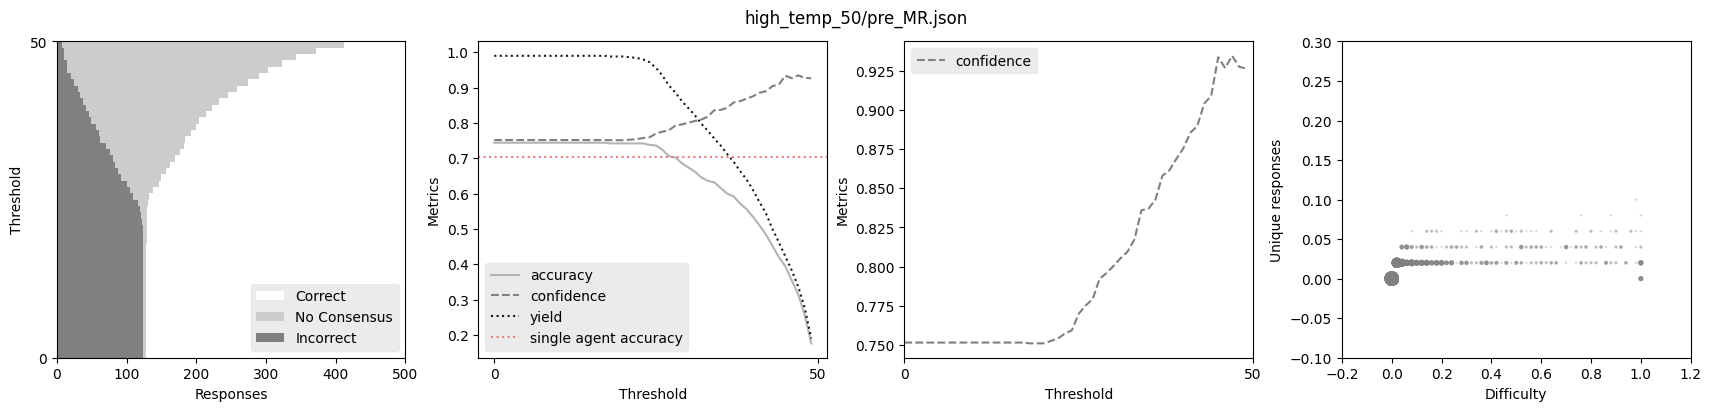

In [14]:
file = json_files[1]
with open(file, 'r') as f:
    data = json.load(f)

responses = []
ground_truth = []
for report in data.values():
    responses.append(report['data'])
    ground_truth.append(report['ground_truth'])

thresholds = 50
running_vals = [[vote_count([vote(responses[i], thresh, ground_truth[i]) for i in range(len(responses))]) for thresh in np.linspace(0, 1, thresholds)]]
answers = ground_truth

mean_values = np.mean(np.array(running_vals), axis=0)

accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
accuracy_mean = np.nanmean(accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

confidence = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
confidence_mean = np.nanmean(confidence, axis=0)

confidence_std = np.nanstd(confidence, axis=0)
confidence_lower = np.nanpercentile(confidence, 2.5, axis=0)
confidence_upper = np.nanpercentile(confidence, 97.5, axis=0)

difficulty = []
for i in range(len(responses)):
    difficulty.append(1-np.sum(np.array(responses[i]) == answers[i])/len(responses[i]))
single_model_acc = 1-float(np.mean(np.array(difficulty)))


fig, ax = plt.subplots(1,4, figsize=(17,4), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, len(answers)])
ax[0].set_yticks([0, thresholds])
ax[0].set_ylabel('Threshold')
ax[0].set_xlabel('Responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(accuracy_mean, color=[0.7,0.7,0.7], label='accuracy')
ax[1].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('Metrics')
ax[1].set_xlabel('Threshold')
ax[1].set_xticks([0, thresholds])
ax[1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[1].legend(loc = 'lower left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[2].set_ylabel('Metrics')
ax[2].set_xlabel('Threshold')
ax[2].set_xlim([0, thresholds])
ax[2].set_xticks([0, thresholds])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# entropy = normalized_entropy(responses)
entropy = simple_entropy(responses)

# ax[3].scatter(entropy, color=[0.5,0.5,0.5], linestyle='--', label='entropy')
c = Counter(zip(difficulty,entropy))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
ax[3].scatter(difficulty, entropy, s=s, color=[0.5, 0.5, 0.5], alpha=0.2)
ax[3].set_xlim([-0.2, 1.2])
ax[3].set_ylim([-0.1, max(entropy)+0.2])
ax[3].set_xlabel('Difficulty')
ax[3].set_ylabel('Unique responses')

plt.suptitle(f'{file}')
plt.savefig('clinical_pre_MR.pdf', format='pdf')

R2 = 0.17737959094035238
rho = 0.42116456515280626


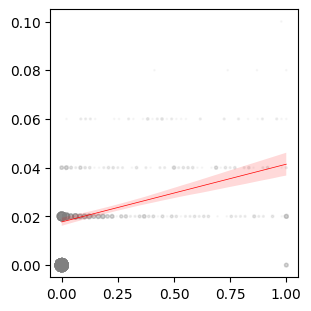

In [15]:
import statsmodels.api as sm
confusion = (np.array(difficulty) - np.array(entropy))/(1 - np.array(entropy))
confusion2 = sm.add_constant(confusion)
model = sm.OLS(entropy, confusion2).fit()
R2 = model.rsquared
print(f'R2 = {R2}')
print(f'rho = {np.sqrt(R2)}')

fig, ax = plt.subplots(1,1, figsize=(3,3), constrained_layout=True)
c = Counter(zip(difficulty,entropy))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
sns.regplot(ax=ax, x=confusion, y=entropy, scatter_kws={'alpha':0.05, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5})


MR_confusion = confusion
MR_uncertainty = entropy
MR_p = np.sqrt(R2)

0.22598218410927495


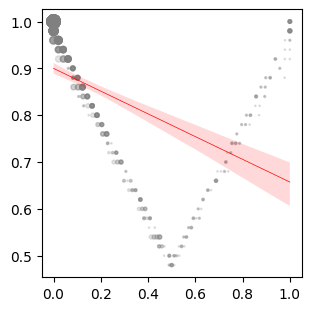

In [16]:
import statsmodels.api as sm
confusion = (np.array(difficulty) - np.array(entropy))/(1 - np.array(entropy))
f = fmax(responses, difficulty)
confusion2 = sm.add_constant(confusion)
model = sm.OLS(f, confusion2).fit()
R2 = model.rsquared
print(R2)

fig, ax = plt.subplots(1,1, figsize=(3,3), constrained_layout=True)
c = Counter(zip(difficulty,f))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,f)]
sns.regplot(ax=ax, x=confusion, y=f, scatter_kws={'alpha':0.2, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5})

MR_confusion = confusion
MR_fmax = f
MR_p = np.sqrt(R2)

(-0.05, 0.15000000000000002)

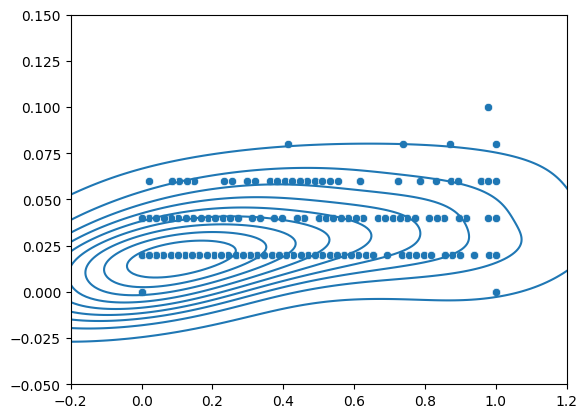

In [17]:
sns.kdeplot(
    x=confusion, y=entropy,
    levels=10,
    bw_adjust=2,
)
sns.scatterplot(x=confusion, y=entropy)

plt.gca().set_xlim([-0.2, 1.2])
plt.gca().set_ylim([-0.05, max(entropy)+0.05])

In [18]:
confidence

array([[0.75151515, 0.75151515, 0.75151515, 0.75151515, 0.75151515,
        0.75151515, 0.75151515, 0.75151515, 0.75151515, 0.75151515,
        0.75151515, 0.75151515, 0.75151515, 0.75151515, 0.75151515,
        0.75151515, 0.75151515, 0.75151515, 0.75101215, 0.75101215,
        0.75101215, 0.7525355 , 0.75406504, 0.75714286, 0.75925926,
        0.76987448, 0.7751606 , 0.77924945, 0.79232506, 0.79582367,
        0.80047506, 0.8053528 , 0.80952381, 0.81748072, 0.83597884,
        0.83695652, 0.84269663, 0.85797101, 0.86144578, 0.86875   ,
        0.87540984, 0.88541667, 0.88970588, 0.904     , 0.90909091,
        0.93364929, 0.92670157, 0.93452381, 0.92753623, 0.92631579]])

In [19]:
single_model_acc

0.70476

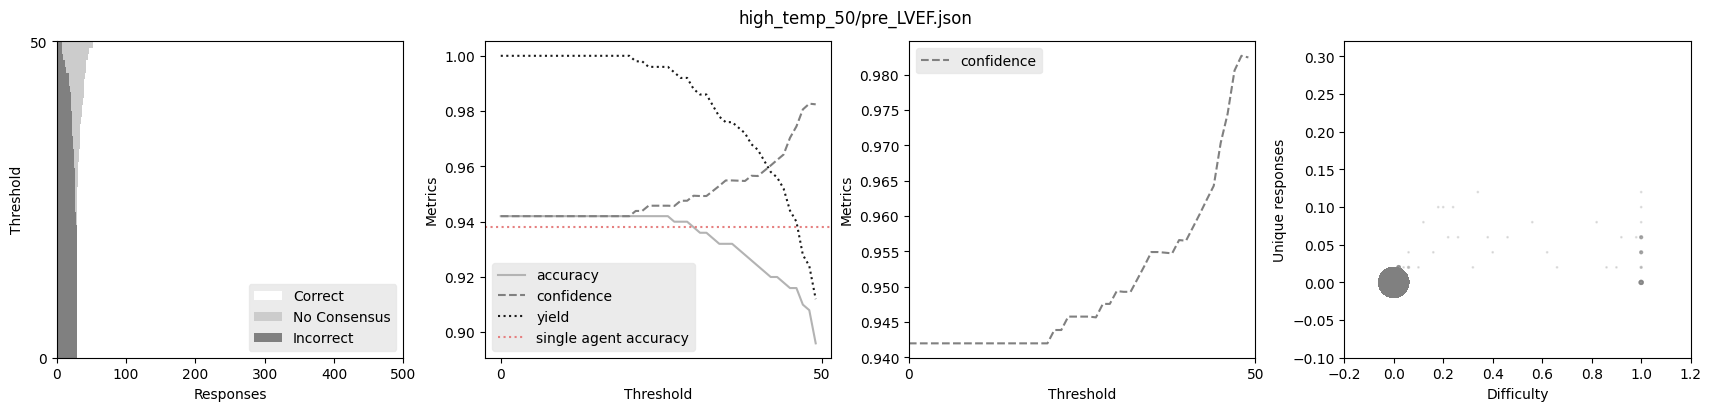

In [20]:
file = json_files[2]
with open(file, 'r') as f:
    data = json.load(f)

responses = []
ground_truth = []
for report in data.values():
    responses.append(report['data'])
    ground_truth.append(report['ground_truth'])

thresholds = 50
running_vals = [[vote_count([vote(responses[i], thresh, ground_truth[i]) for i in range(len(responses))]) for thresh in np.linspace(0, 1, thresholds)]]
answers = ground_truth

mean_values = np.mean(np.array(running_vals), axis=0)

accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
accuracy_mean = np.nanmean(accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

confidence = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
confidence_mean = np.nanmean(confidence, axis=0)

confidence_std = np.nanstd(confidence, axis=0)
confidence_lower = np.nanpercentile(confidence, 2.5, axis=0)
confidence_upper = np.nanpercentile(confidence, 97.5, axis=0)

difficulty = []
for i in range(len(responses)):
    converted_responses = np.array([-1 if r == 'N/A' else int(float(r)) for r in responses[i]])
    converted_answer = -1 if answers[i][0] == 'N/A' else int(float(answers[i][0]))
    difficulty.append(1-np.sum(converted_responses == converted_answer)/len(responses[i]))
single_model_acc = 1-float(np.mean(np.array(difficulty)))


fig, ax = plt.subplots(1,4, figsize=(17,4), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, len(answers)])
ax[0].set_yticks([0, thresholds])
ax[0].set_ylabel('Threshold')
ax[0].set_xlabel('Responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(accuracy_mean, color=[0.7,0.7,0.7], label='accuracy')
ax[1].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('Metrics')
ax[1].set_xlabel('Threshold')
ax[1].set_xticks([0, thresholds])
ax[1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[1].legend(loc = 'lower left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[2].set_ylabel('Metrics')
ax[2].set_xlabel('Threshold')
ax[2].set_xlim([0, thresholds])
ax[2].set_xticks([0, thresholds])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# entropy = normalized_entropy(responses)
entropy = simple_entropy(responses)

# ax[3].scatter(entropy, color=[0.5,0.5,0.5], linestyle='--', label='entropy')
c = Counter(zip(difficulty,entropy))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
ax[3].scatter(difficulty, entropy, s=s, color=[0.5, 0.5, 0.5], alpha=0.2)
ax[3].set_xlim([-0.2, 1.2])
ax[3].set_ylim([-0.1, max(entropy)+0.2])
ax[3].set_xlabel('Difficulty')
ax[3].set_ylabel('Unique responses')

plt.suptitle(f'{file}')
plt.savefig('clinical_pre_LVEF.pdf', format='pdf')

R2 = 0.3265834592392677
rho = 0.5714748106778352


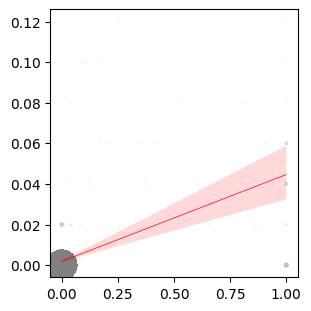

In [21]:
import statsmodels.api as sm
confusion = (np.array(difficulty) - np.array(entropy))/(1 - np.array(entropy))
confusion2 = sm.add_constant(confusion)
model = sm.OLS(entropy, confusion2).fit()
R2 = model.rsquared
print(f'R2 = {R2}')
print(f'rho = {np.sqrt(R2)}')

fig, ax = plt.subplots(1,1, figsize=(3,3), constrained_layout=True)
c = Counter(zip(difficulty,entropy))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
sns.regplot(ax=ax, x=confusion, y=entropy, scatter_kws={'alpha':0.05, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5})


EF_confusion = confusion
EF_uncertainty = entropy
EF_p = np.sqrt(R2)

0.16144803943781605


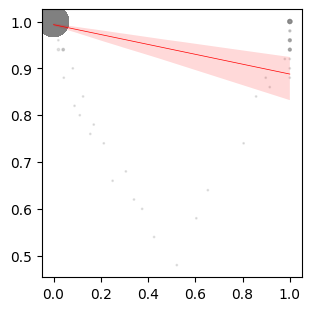

In [22]:
import statsmodels.api as sm
confusion = (np.array(difficulty) - np.array(entropy))/(1 - np.array(entropy))
f = fmax(responses, difficulty)
confusion2 = sm.add_constant(confusion)
model = sm.OLS(f, confusion2).fit()
R2 = model.rsquared
print(R2)

fig, ax = plt.subplots(1,1, figsize=(3,3), constrained_layout=True)
c = Counter(zip(difficulty,f))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,f)]
sns.regplot(ax=ax, x=confusion, y=f, scatter_kws={'alpha':0.2, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5})

EF_confusion = confusion
EF_fmax = f
EF_p = np.sqrt(R2)

(-0.05, 0.16999999999999998)

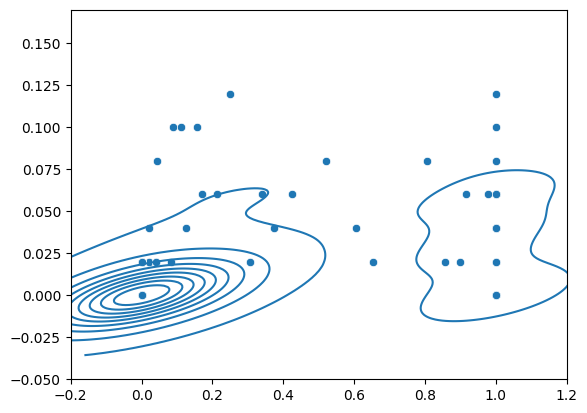

In [23]:
sns.kdeplot(
    x=confusion, y=entropy,
    levels=10,
    bw_adjust=2,
)
sns.scatterplot(x=confusion, y=entropy)

plt.gca().set_xlim([-0.2, 1.2])
plt.gca().set_ylim([-0.05, max(entropy)+0.05])

In [24]:
confidence

array([[0.942     , 0.942     , 0.942     , 0.942     , 0.942     ,
        0.942     , 0.942     , 0.942     , 0.942     , 0.942     ,
        0.942     , 0.942     , 0.942     , 0.942     , 0.942     ,
        0.942     , 0.942     , 0.942     , 0.942     , 0.942     ,
        0.942     , 0.94388778, 0.94388778, 0.94578313, 0.94578313,
        0.94578313, 0.94578313, 0.94567404, 0.94758065, 0.94758065,
        0.94939271, 0.94929006, 0.94929006, 0.95112016, 0.95296524,
        0.95491803, 0.95491803, 0.95482546, 0.95473251, 0.95661157,
        0.95652174, 0.95841996, 0.96033403, 0.9623431 , 0.96428571,
        0.97033898, 0.97446809, 0.98060345, 0.98268398, 0.98245614]])

In [25]:
single_model_acc

0.93792

In [26]:
import scipy
scipy.stats.pearsonr(confusion, entropy)

PearsonRResult(statistic=np.float64(0.5714748106778353), pvalue=np.float64(1.0889259857937836e-44))

In [27]:
file = json_files[3]
with open(file, 'r') as f:
    data = json.load(f)

responses = []
ground_truth = []
for report in data.values():
    responses.append(report['data'])
    ground_truth.append(report['ground_truth'])

thresholds = 20
running_vals = [[vote_count([vote(responses[i], thresh, ground_truth[i]) for i in range(len(responses))]) for thresh in np.linspace(0, 1, thresholds)]]
answers = ground_truth

mean_values = np.mean(np.array(running_vals), axis=0)

accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
accuracy_mean = np.nanmean(accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

confidence = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
confidence_mean = np.nanmean(confidence, axis=0)

confidence_std = np.nanstd(confidence, axis=0)
confidence_lower = np.nanpercentile(confidence, 2.5, axis=0)
confidence_upper = np.nanpercentile(confidence, 97.5, axis=0)

difficulty = []
for i in range(len(responses)):
    converted_responses = np.array([-1 if r == 'N/A' else int(float(r)) for r in responses[i]])
    converted_answer = -1 if answers[i][0] == 'N/A' else int(float(answers[i][0]))
    difficulty.append(1-np.sum(converted_responses == converted_answer)/len(responses[i]))
single_model_acc = 1-float(np.mean(np.array(difficulty)))


fig, ax = plt.subplots(1,4, figsize=(17,4), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, len(answers)])
ax[0].set_yticks([0, thresholds])
ax[0].set_ylabel('threshold')
ax[0].set_xlabel('responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(accuracy_mean, color=[0.7,0.7,0.7], label='accuracy')
ax[1].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('threshold')
ax[1].set_xticks([0, thresholds])
ax[1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[2].set_ylabel('metrics')
ax[2].set_xlabel('threshold')
ax[2].set_xlim([0, thresholds])
ax[2].set_xticks([0, thresholds])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# entropy = normalized_entropy(responses)
entropy = simple_entropy(responses)

# ax[3].scatter(entropy, color=[0.5,0.5,0.5], linestyle='--', label='entropy')
c = Counter(zip(difficulty,entropy))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
ax[3].scatter(difficulty, entropy, s=s, color=[0.5, 0.5, 0.5], alpha=0.2)
ax[3].set_xlim([-0.2, 1.2])
ax[3].set_ylim([-0.1, max(entropy)+0.2])
ax[3].set_xlabel('difficulty')
ax[3].set_ylabel('Unique responses')

plt.suptitle(f'{file}')

IndexError: list index out of range

In [105]:
file = json_files[4]
with open(file, 'r') as f:
    data = json.load(f)

responses = []
ground_truth = []
for report in data.values():
    responses.append(report['data'])
    ground_truth.append(report['ground_truth'])

thresholds = 20
running_vals = [[vote_count([vote(responses[i], thresh, ground_truth[i]) for i in range(len(responses))]) for thresh in np.linspace(0, 1, thresholds)]]
answers = ground_truth

mean_values = np.mean(np.array(running_vals), axis=0)

accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
accuracy_mean = np.nanmean(accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

confidence = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
confidence_mean = np.nanmean(confidence, axis=0)

confidence_std = np.nanstd(confidence, axis=0)
confidence_lower = np.nanpercentile(confidence, 2.5, axis=0)
confidence_upper = np.nanpercentile(confidence, 97.5, axis=0)

difficulty = []
for i in range(len(responses)):
    difficulty.append(1-np.sum(np.array(responses[i]) == answers[i])/len(responses[i]))
single_model_acc = 1-float(np.mean(np.array(difficulty)))


fig, ax = plt.subplots(1,4, figsize=(17,4), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, len(answers)])
ax[0].set_yticks([0, thresholds])
ax[0].set_ylabel('threshold')
ax[0].set_xlabel('responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(accuracy_mean, color=[0.7,0.7,0.7], label='accuracy')
ax[1].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('threshold')
ax[1].set_xticks([0, thresholds])
ax[1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[2].set_ylabel('metrics')
ax[2].set_xlabel('threshold')
ax[2].set_xlim([0, thresholds])
ax[2].set_xticks([0, thresholds])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# entropy = normalized_entropy(responses)
entropy = simple_entropy(responses)

# ax[3].scatter(entropy, color=[0.5,0.5,0.5], linestyle='--', label='entropy')
c = Counter(zip(difficulty,entropy))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
ax[3].scatter(difficulty, entropy, s=s, color=[0.5, 0.5, 0.5], alpha=0.2)
ax[3].set_xlim([-0.2, 1.2])
ax[3].set_ylim([-0.1, max(entropy)+0.2])
ax[3].set_xlabel('difficulty')
ax[3].set_ylabel('Unique responses')

plt.suptitle(f'{file}')

IndexError: list index out of range

Text(0.5, 0.98, 'results/post_AS.json')

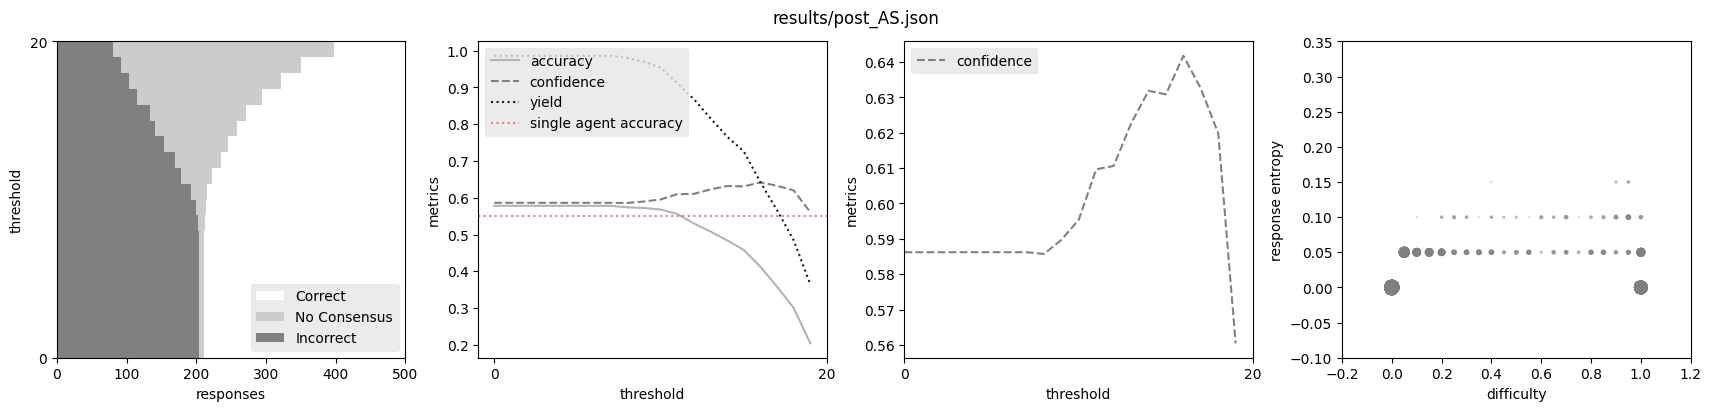

In [54]:
file = json_files[5]
with open(file, 'r') as f:
    data = json.load(f)

responses = []
ground_truth = []
for report in data.values():
    responses.append(report['data'])
    ground_truth.append(report['ground_truth'])

thresholds = 20
running_vals = [[vote_count([vote(responses[i], thresh, ground_truth[i]) for i in range(len(responses))]) for thresh in np.linspace(0, 1, thresholds)]]
answers = ground_truth

mean_values = np.mean(np.array(running_vals), axis=0)

accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
accuracy_mean = np.nanmean(accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

confidence = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
confidence_mean = np.nanmean(confidence, axis=0)

confidence_std = np.nanstd(confidence, axis=0)
confidence_lower = np.nanpercentile(confidence, 2.5, axis=0)
confidence_upper = np.nanpercentile(confidence, 97.5, axis=0)

difficulty = []
for i in range(len(responses)):
    difficulty.append(1-np.sum(np.array(responses[i]) == answers[i])/len(responses[i]))
single_model_acc = 1-float(np.mean(np.array(difficulty)))


fig, ax = plt.subplots(1,4, figsize=(17,4), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, len(answers)])
ax[0].set_yticks([0, thresholds])
ax[0].set_ylabel('threshold')
ax[0].set_xlabel('responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(accuracy_mean, color=[0.7,0.7,0.7], label='accuracy')
ax[1].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('threshold')
ax[1].set_xticks([0, thresholds])
ax[1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[2].set_ylabel('metrics')
ax[2].set_xlabel('threshold')
ax[2].set_xlim([0, thresholds])
ax[2].set_xticks([0, thresholds])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# entropy = normalized_entropy(responses)
entropy = simple_entropy(responses)

# ax[3].scatter(entropy, color=[0.5,0.5,0.5], linestyle='--', label='entropy')
c = Counter(zip(difficulty,entropy))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
ax[3].scatter(difficulty, entropy, s=s, color=[0.5, 0.5, 0.5], alpha=0.2)
ax[3].set_xlim([-0.2, 1.2])
ax[3].set_ylim([-0.1, max(entropy)+0.2])
ax[3].set_xlabel('difficulty')
ax[3].set_ylabel('Unique responses')

plt.suptitle(f'{file}')

Text(0.5, 0.98, 'results/pre_MR.json')

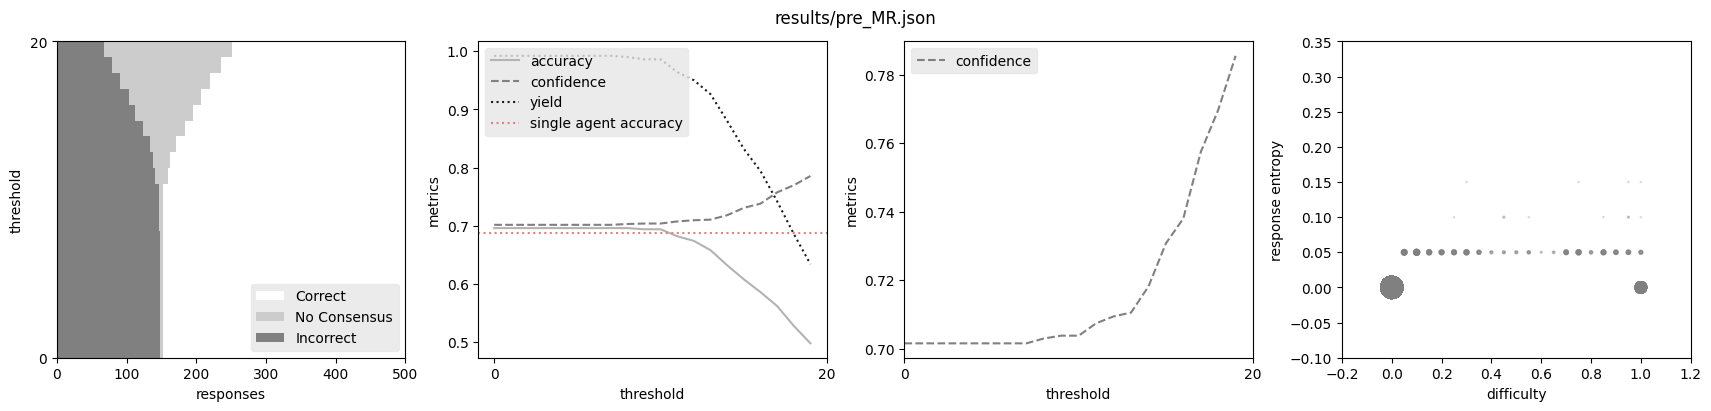

In [58]:
file = json_files[6]
with open(file, 'r') as f:
    data = json.load(f)

responses = []
ground_truth = []
for report in data.values():
    responses.append(report['data'])
    ground_truth.append(report['ground_truth'])

thresholds = 20
running_vals = [[vote_count([vote(responses[i], thresh, ground_truth[i]) for i in range(len(responses))]) for thresh in np.linspace(0, 1, thresholds)]]
answers = ground_truth

mean_values = np.mean(np.array(running_vals), axis=0)

accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
accuracy_mean = np.nanmean(accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

confidence = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
confidence_mean = np.nanmean(confidence, axis=0)

confidence_std = np.nanstd(confidence, axis=0)
confidence_lower = np.nanpercentile(confidence, 2.5, axis=0)
confidence_upper = np.nanpercentile(confidence, 97.5, axis=0)

difficulty = []
for i in range(len(responses)):
    difficulty.append(1-np.sum(np.array(responses[i]) == answers[i])/len(responses[i]))
single_model_acc = 1-float(np.mean(np.array(difficulty)))


fig, ax = plt.subplots(1,4, figsize=(17,4), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, len(answers)])
ax[0].set_yticks([0, thresholds])
ax[0].set_ylabel('threshold')
ax[0].set_xlabel('responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(accuracy_mean, color=[0.7,0.7,0.7], label='accuracy')
ax[1].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('threshold')
ax[1].set_xticks([0, thresholds])
ax[1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[2].set_ylabel('metrics')
ax[2].set_xlabel('threshold')
ax[2].set_xlim([0, thresholds])
ax[2].set_xticks([0, thresholds])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# entropy = normalized_entropy(responses)
entropy = simple_entropy(responses)

# ax[3].scatter(entropy, color=[0.5,0.5,0.5], linestyle='--', label='entropy')
c = Counter(zip(difficulty,entropy))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
ax[3].scatter(difficulty, entropy, s=s, color=[0.5, 0.5, 0.5], alpha=0.2)
ax[3].set_xlim([-0.2, 1.2])
ax[3].set_ylim([-0.1, max(entropy)+0.2])
ax[3].set_xlabel('difficulty')
ax[3].set_ylabel('Unique responses')

plt.suptitle(f'{file}')

Text(0.5, 0.98, 'results/pre_LVEF.json')

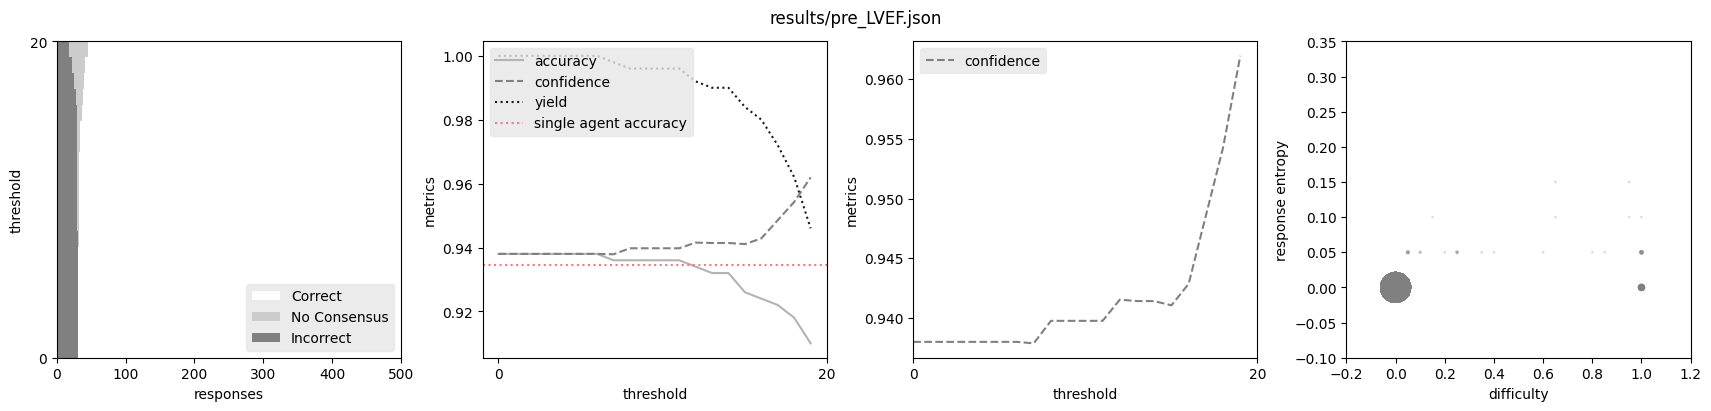

In [56]:
file = json_files[7]
with open(file, 'r') as f:
    data = json.load(f)

responses = []
ground_truth = []
for report in data.values():
    responses.append(report['data'])
    ground_truth.append(report['ground_truth'])

thresholds = 20
running_vals = [[vote_count([vote(responses[i], thresh, ground_truth[i]) for i in range(len(responses))]) for thresh in np.linspace(0, 1, thresholds)]]
answers = ground_truth

mean_values = np.mean(np.array(running_vals), axis=0)

accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
accuracy_mean = np.nanmean(accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

confidence = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
confidence_mean = np.nanmean(confidence, axis=0)

confidence_std = np.nanstd(confidence, axis=0)
confidence_lower = np.nanpercentile(confidence, 2.5, axis=0)
confidence_upper = np.nanpercentile(confidence, 97.5, axis=0)

difficulty = []
for i in range(len(responses)):
    converted_responses = np.array([-1 if r == 'N/A' else int(float(r)) for r in responses[i]])
    converted_answer = -1 if answers[i][0] == 'N/A' else int(float(answers[i][0]))
    difficulty.append(1-np.sum(converted_responses == converted_answer)/len(responses[i]))
single_model_acc = 1-float(np.mean(np.array(difficulty)))


fig, ax = plt.subplots(1,4, figsize=(17,4), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, len(answers)])
ax[0].set_yticks([0, thresholds])
ax[0].set_ylabel('threshold')
ax[0].set_xlabel('responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(accuracy_mean, color=[0.7,0.7,0.7], label='accuracy')
ax[1].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('threshold')
ax[1].set_xticks([0, thresholds])
ax[1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(confidence_mean, color=[0.5,0.5,0.5], linestyle='--', label='confidence')
ax[2].set_ylabel('metrics')
ax[2].set_xlabel('threshold')
ax[2].set_xlim([0, thresholds])
ax[2].set_xticks([0, thresholds])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# entropy = normalized_entropy(responses)
entropy = simple_entropy(responses)

# ax[3].scatter(entropy, color=[0.5,0.5,0.5], linestyle='--', label='entropy')
c = Counter(zip(difficulty,entropy))
s = [(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
ax[3].scatter(difficulty, entropy, s=s, color=[0.5, 0.5, 0.5], alpha=0.2)
ax[3].set_xlim([-0.2, 1.2])
ax[3].set_ylim([-0.1, max(entropy)+0.2])
ax[3].set_xlabel('difficulty')
ax[3].set_ylabel('Unique responses')

plt.suptitle(f'{file}')

In [60]:
responses[3]

['0',
 '3',
 '3',
 '0',
 '3',
 '0',
 '3',
 '0',
 '0',
 '0',
 '0',
 '3',
 '0',
 '0',
 '3',
 '3',
 '3',
 '0',
 '0',
 '3']

In [62]:
responses[12]

['3',
 '0',
 '3',
 '0',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3']

In [59]:
simple_entropy(responses)

[0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.05,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.05,
 0.05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.05,
 0.0,
 0.0,
 0.05,
 0.05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.05,
 0.05,
 0.0,
 0.05,
 0.05,
 0.05,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.05,
 0.0,
 0.05,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.05,
 0.05,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.05,
 0.05,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.05,
 0.0,
 0.1,
 0.05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.05,
 0.0,
 0.0,
 0.05,
 0.05,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.05,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.05,
 0.05,
 0.05,
 0.0,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.0

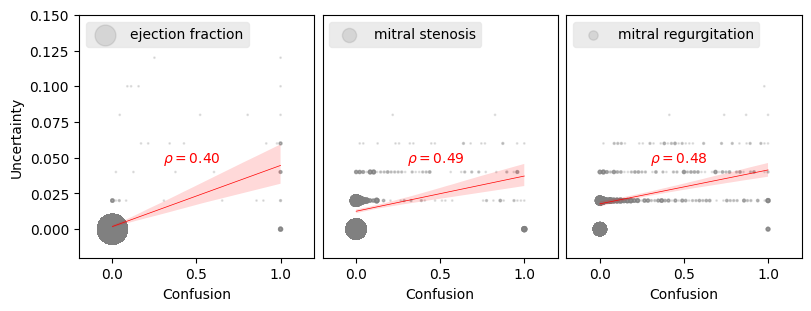

In [28]:
fig, ax = plt.subplots(1,3, figsize=(8,3), constrained_layout=True)

c = Counter(zip(EF_confusion,EF_uncertainty))
s = [(c[(xx,yy)]) for xx,yy in zip(EF_confusion,EF_uncertainty)]
# ax[0].scatter(EF_confusion, EF_uncertainty, s=s, color=[0.5, 0.5, 0.5], alpha=0.2, label='ejection fraction')
sns.regplot(ax=ax[0], x=EF_confusion, y=EF_uncertainty, scatter_kws={'alpha':0.2, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5}, label='ejection fraction')


c = Counter(zip(MS_confusion,MS_uncertainty))
s = [(c[(xx,yy)]) for xx,yy in zip(MS_confusion,MS_uncertainty)]
# ax[1].scatter(MS_confusion, MS_uncertainty, s=s, color=[0.5, 0.5, 0.5], alpha=0.2, label='mitral stenosis')
sns.regplot(ax=ax[1], x=MS_confusion, y=MS_uncertainty, scatter_kws={'alpha':0.2, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5}, label='mitral stenosis')

c = Counter(zip(MR_confusion,MR_uncertainty))
s = [(c[(xx,yy)]) for xx,yy in zip(MR_confusion,MR_uncertainty)]
# ax[2].scatter(MR_confusion, MR_uncertainty, s=s, color=[0.5, 0.5, 0.5], alpha=0.2, label='mitral regurgitation')
sns.regplot(ax=ax[2], x=MR_confusion, y=MR_uncertainty, scatter_kws={'alpha':0.2, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5}, label='mitral regurgitation')


ax[0].set_ylabel('Uncertainty')
for a in ax:
    a.set_xlim([-0.2, 1.2])
    a.set_ylim([-0.02, 0.15])
    a.legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])
    a.set_xlabel('Confusion')
ax[1].set_yticks([])
ax[2].set_yticks([])

ax[0].text(0.3, 0.047, f'$\\rho = ${EF_p:.2f}', fontsize=10, color='r')
ax[1].text(0.3, 0.047, f'$\\rho = ${MS_p:.2f}', fontsize=10, color='r')
ax[2].text(0.3, 0.047, f'$\\rho = ${MR_p:.2f}', fontsize=10, color='r')

plt.savefig('clinical_questiondomain.pdf', format='pdf', bbox_inches='tight')

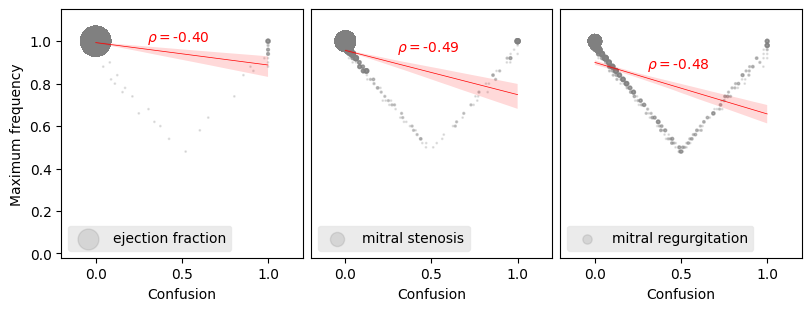

In [44]:
fig, ax = plt.subplots(1,3, figsize=(8,3), constrained_layout=True)

c = Counter(zip(EF_confusion,EF_fmax))
s = [(c[(xx,yy)]) for xx,yy in zip(EF_confusion,EF_fmax)]
# ax[0].scatter(EF_confusion, EF_fmax, s=s, color=[0.5, 0.5, 0.5], alpha=0.2, label='ejection fraction')
sns.regplot(ax=ax[0], x=EF_confusion, y=EF_fmax, scatter_kws={'alpha':0.2, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5}, label='ejection fraction')


c = Counter(zip(MS_confusion,MS_fmax))
s = [(c[(xx,yy)]) for xx,yy in zip(MS_confusion,MS_fmax)]
# ax[1].scatter(MS_confusion, MS_fmax, s=s, color=[0.5, 0.5, 0.5], alpha=0.2, label='mitral stenosis')
sns.regplot(ax=ax[1], x=MS_confusion, y=MS_fmax, scatter_kws={'alpha':0.2, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5}, label='mitral stenosis')

c = Counter(zip(MR_confusion,MR_fmax))
s = [(c[(xx,yy)]) for xx,yy in zip(MR_confusion,MR_fmax)]
# ax[2].scatter(MR_confusion, MR_fmax, s=s, color=[0.5, 0.5, 0.5], alpha=0.2, label='mitral regurgitation')
sns.regplot(ax=ax[2], x=MR_confusion, y=MR_fmax, scatter_kws={'alpha':0.2, 'color':[0.5,0.5,0.5], 's':s}, line_kws={'color':'r', 'linewidth':0.5}, label='mitral regurgitation')


ax[0].set_ylabel('Maximum frequency')
for a in ax:
    a.set_xlim([-0.2, 1.2])
    a.set_ylim([-0.02, 1.15])
    a.legend(loc = 'lower left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])
    a.set_xlabel('Confusion')
ax[1].set_yticks([])
ax[2].set_yticks([])

ax[0].text(0.3, 1, f'$\\rho = $-{EF_p:.2f}', fontsize=10, color='r')
ax[1].text(0.3, 0.95, f'$\\rho = $-{MS_p:.2f}', fontsize=10, color='r')
ax[2].text(0.3, 0.87, f'$\\rho = $-{MR_p:.2f}', fontsize=10, color='r')

plt.savefig('clinical_questiondomain.pdf', format='pdf', bbox_inches='tight')